In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "thebilly" 
os.environ["KAGGLE_KEY"] = "93e9a84ee116cc537d8af7cb62260c6e"
! kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:36<00:00, 24.1MB/s]
100% 812M/812M [00:36<00:00, 23.3MB/s]


In [21]:
import zipfile
local_zip = '/content/dogs-vs-cats.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [22]:
train_data = '/content/train.zip'
zip_train = zipfile.ZipFile(train_data, 'r')
zip_train.extractall()
zip_train.close()

In [23]:
path, dirs, files = next(os.walk('/content/train'))
file_count = len(files)
print('Number of images: ', file_count)

Number of images:  25000


In [25]:
test_data = '/content/test1.zip'
zip_test = zipfile.ZipFile(test_data, 'r')
zip_test.extractall()
zip_test.close()

In [26]:
path, dirs, files = next(os.walk('/content/test1'))
file_count = len(files)
print('Number of images: ', file_count)

Number of images:  12500


In [27]:
file_names = os.listdir('/content/train/')

dog_count = 0
cat_count = 0

for img_file in file_names:

  name = img_file[0:3]

  if name == 'dog':
    dog_count += 1

  else:
    cat_count += 1

print('Number of dog images =', dog_count)
print('Number of cat images =', cat_count)

Number of dog images = 12500
Number of cat images = 12500


In [29]:
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
 
 labeldirs = ['dogs/', 'cats/']
 for labldir in labeldirs:
  newdir = dataset_home + subdir + labldir
  os.makedirs(newdir, exist_ok=True)

In [33]:
from random import random
from shutil import copyfile
val_ratio = 0.25
src_directory = '/content/train'
for file in os.listdir(src_directory):
  src = os.path.join(src_directory,file)
  dst_dir = 'train/'
  if random() < val_ratio:
    dst_dir = 'test/'
  if file.startswith('cat'):
    dst = dataset_home + dst_dir + 'cats/'  + file
    copyfile(src, dst)
  elif file.startswith('dog'):
    dst = dataset_home + dst_dir + 'dogs/'  + file
    copyfile(src, dst)


In [34]:
path, dirs, files = next(os.walk('/content/dataset_dogs_vs_cats/train/cats'))
file_count = len(files)
print('Number of images: ', file_count)

Number of images:  9365


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')


  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))
  
  validation_datagen = ImageDataGenerator(rescale=1/255)

  
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  
  return train_generator, validation_generator

In [39]:
TRAINING_DIR = '/content/dataset_dogs_vs_cats/train'
VALIDATION_DIR = '/content/dataset_dogs_vs_cats/test'
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)
print(train_generator.class_indices,validation_generator.class_indices)

Found 18742 images belonging to 2 classes.
Found 6259 images belonging to 2 classes.
{'cats': 0, 'dogs': 1} {'cats': 0, 'dogs': 1}


In [48]:
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
def define_model():
	
	model = VGG16(include_top=False, input_shape=(150, 150, 3))
	
	for layer in model.layers:
		layer.trainable = False
	
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	
	model = Model(inputs=model.inputs, outputs=output)
	
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model


In [49]:
model = define_model()
history = model.fit(train_generator,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/10
938/938 [==============================] - 175s 184ms/step - loss: 0.4422 - accuracy: 0.7858 - val_loss: 0.2679 - val_accuracy: 0.8858
Epoch 2/10
938/938 [==============================] - 181s 193ms/step - loss: 0.3729 - accuracy: 0.8318 - val_loss: 0.2664 - val_accuracy: 0.8851
Epoch 3/10
938/938 [==============================] - 170s 181ms/step - loss: 0.3522 - accuracy: 0.8398 - val_loss: 0.2419 - val_accuracy: 0.8982
Epoch 4/10
938/938 [==============================] - 171s 182ms/step - loss: 0.3391 - accuracy: 0.8471 - val_loss: 0.2512 - val_accuracy: 0.8925
Epoch 5/10
938/938 [==============================] - 171s 182ms/step - loss: 0.3332 - accuracy: 0.8516 - val_loss: 0.2351 - val_accuracy: 0.8990
Epoch 6/10
938/938 [==============================] - 170s 181ms/step - loss: 0.3348 - accuracy: 0.8483 - val_loss: 0.2460 - val_accuracy: 0.8931
Epoch 7/10
938/938 [==============================] - 169s 

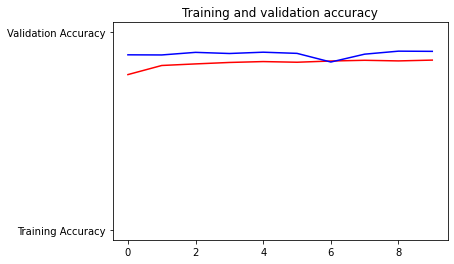

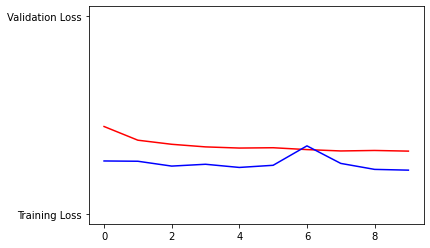

In [50]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [51]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving dogs-g5f82af0af_640.jpg to dogs-g5f82af0af_640.jpg
1/1 [==============================] - 1s 762ms/step
[0.7254006]
dogs-g5f82af0af_640.jpg is a dog
